In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import seaborn as sns
import itertools
import os
import pandas as pd

from torch.autograd import Variable
from torch.optim import lr_scheduler
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
BATCH_SIZE = 100
N_ITER = 2500
EPOCHS = 15

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [59000, 1000])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

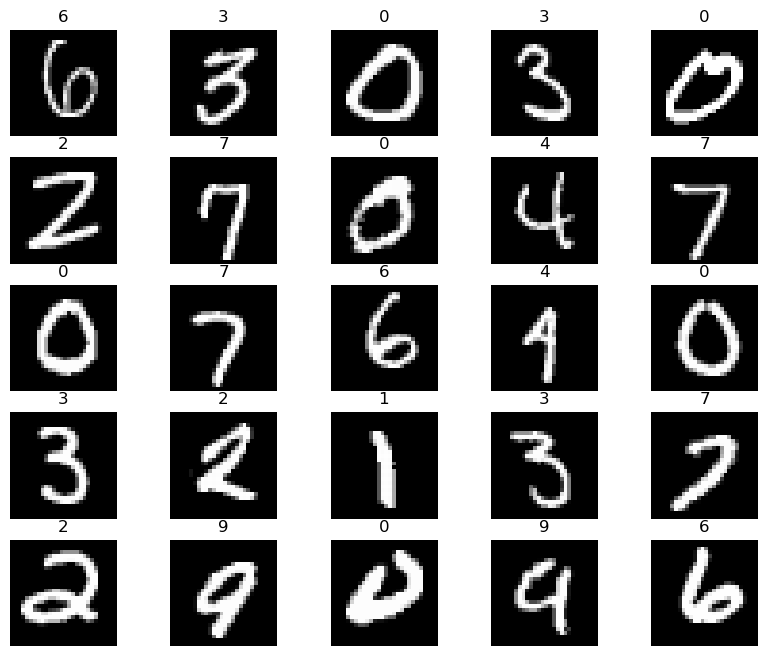

In [3]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # convolution 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # maxpool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        # dropout 1
        self.dropout1 = nn.Dropout(0.25)
        
        # convolution 2
        self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # maxpool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        # dropout 2
        self.dropout2 = nn.Dropout(0.25)
        
        # linear 1
        self.fc1 = nn.Linear(32*5*5, 256)
        
        # dropout 3
        self.dropout3 = nn.Dropout(0.25)
        
        # linear 2
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        
        out = self.c1(x) # [BATCH_SIZE, 16, 24, 24]
        out = self.relu1(out) 
        out = self.maxpool1(out) # [BATCH_SIZE, 16, 12, 12]
        out = self.dropout1(out) 
        
        out = self.c2(out) # [BATCH_SIZE, 32, 10, 10]
        out = self.relu2(out) 
        out = self.maxpool2(out) # [BATCH_SIZE, 32, 5, 5]
        out = self.dropout2(out) 
        
        out = out.view(out.size(0), -1) # [BATCH_SIZE, 32*5*5=800]
        out = self.fc1(out) # [BATCH_SIZE, 256]
        out = self.dropout3(out)
        out = self.fc2(out) # [BATCH_SIZE, 10]
        
        return out

model = CNN()
model

CNN(
  (c1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# LR scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# On GPU if possible
if torch.cuda.is_available():
    print("Model will be training on GPU")
    model = model.cuda()
    criterion = criterion.cuda()
else:
    print("Model will be training on CPU")

Model will be training on GPU


In [6]:
def fit(epoch):
    
    print("Training...")
    # Set model on training mode
    model.train()
    
    # Update lr parameter
    exp_lr_scheduler.step()
    
    # Initialize train loss and train accuracy
    train_running_loss = 0.0
    train_running_correct = 0
    train_running_lr = optimizer.param_groups[0]['lr']
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data.view(BATCH_SIZE,1,28,28)), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch+1, 
                 (batch_idx + 1) * len(data), 
                 len(train_loader.dataset),
                 BATCH_SIZE * (batch_idx + 1) / len(train_loader), 
                 loss.cpu().detach().numpy())
                 )
            
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)    
    
    return train_loss, train_accuracy, train_running_lr

In [7]:
def validate(data_loader):
    
    print("Validating...")
    # Set model on validating mode
    model.eval()
    val_preds = torch.LongTensor().cuda()
    val_proba = torch.LongTensor().cuda()
    
    # Initialize validation loss and validation accuracy
    val_running_loss = 0.0
    val_running_correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data.view(BATCH_SIZE,1,28,28), volatile=True), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        proba = torch.nn.functional.softmax(output.data)

        val_running_correct += pred.eq(target.data.view_as(pred)).cpu().sum() 
        
        # Store val_predictions with probas for confusion matrix calculations & best errors made
        val_preds = torch.cat((val_preds, pred), dim=0)
        val_proba = torch.cat((val_proba, proba))

    val_loss = val_running_loss/len(data_loader.dataset)
    val_accuracy = 100. * val_running_correct/len(data_loader.dataset) 
    
    return val_loss, val_accuracy, val_preds, val_proba

In [8]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
val_preds, val_proba = [], []
train_lr = []

for epoch in range(EPOCHS):
    
    print(f"Epoch {epoch+1} of {EPOCHS}\n")
    
    train_epoch_loss, train_epoch_accuracy, train_epoch_lr = fit(epoch)
    val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_proba = validate(val_loader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_lr.append(train_epoch_lr)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_preds.append(val_epoch_preds)
    val_proba.append(val_epoch_proba)
    
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}\n')

Epoch 1 of 15

Training...
Train Epoch: 1 [5000/59000 (8%)]	Loss: 0.311028
Train Epoch: 1 [10000/59000 (17%)]	Loss: 0.348596
Train Epoch: 1 [15000/59000 (25%)]	Loss: 0.163265
Train Epoch: 1 [20000/59000 (34%)]	Loss: 0.296042
Train Epoch: 1 [25000/59000 (42%)]	Loss: 0.089560
Train Epoch: 1 [30000/59000 (51%)]	Loss: 0.119605
Train Epoch: 1 [35000/59000 (59%)]	Loss: 0.149890
Train Epoch: 1 [40000/59000 (68%)]	Loss: 0.206583
Train Epoch: 1 [45000/59000 (76%)]	Loss: 0.101337
Train Epoch: 1 [50000/59000 (85%)]	Loss: 0.057789
Train Epoch: 1 [55000/59000 (93%)]	Loss: 0.137550
Validating...
Train Loss: 0.0020, Train Acc: 93.75
Val Loss: 0.0005, Val Acc: 97.90

Epoch 2 of 15

Training...
Train Epoch: 2 [5000/59000 (8%)]	Loss: 0.037237
Train Epoch: 2 [10000/59000 (17%)]	Loss: 0.071631
Train Epoch: 2 [15000/59000 (25%)]	Loss: 0.022280
Train Epoch: 2 [20000/59000 (34%)]	Loss: 0.111889
Train Epoch: 2 [25000/59000 (42%)]	Loss: 0.179975
Train Epoch: 2 [30000/59000 (51%)]	Loss: 0.106165
Train Epoch: 2 

In [9]:
# save model checkpoint
torch.save({'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,},
           './model.pth')

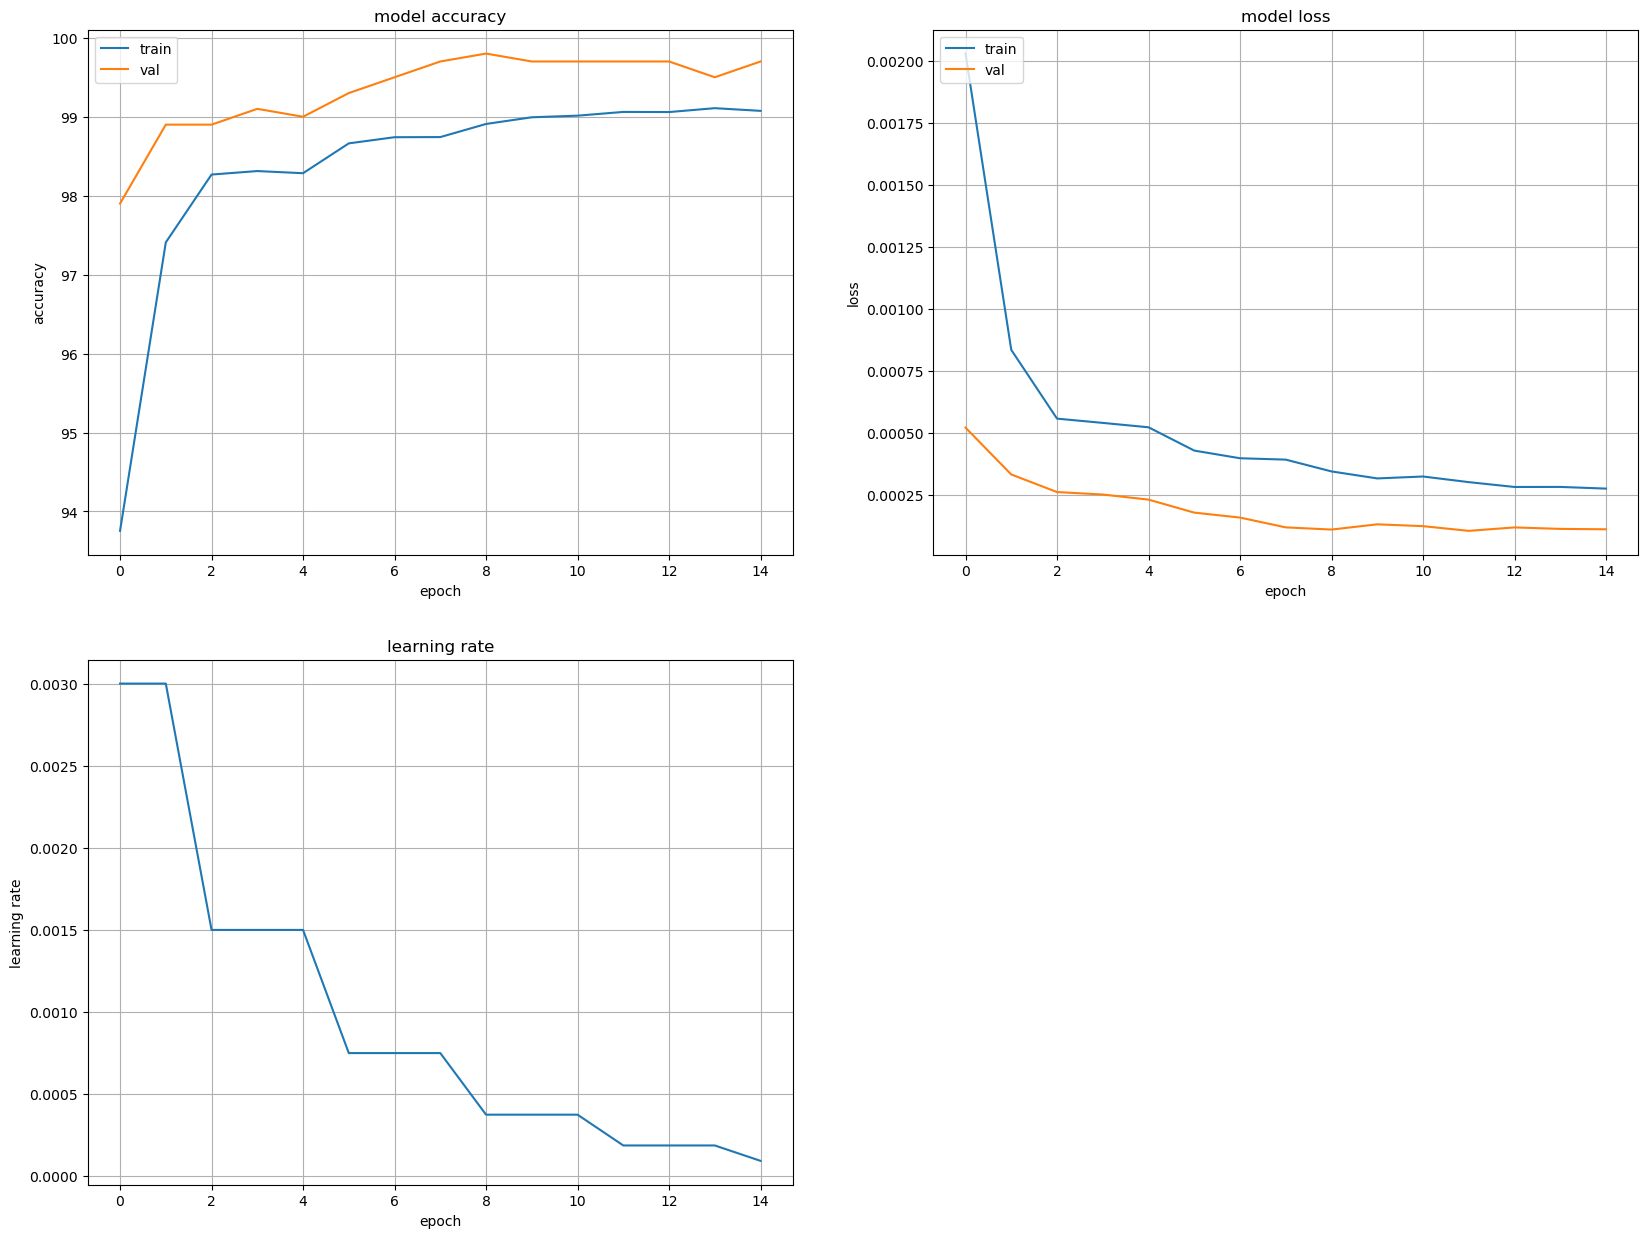

In [10]:
def plot_history():

    plt.figure(figsize = (20,15))
    
    plt.subplot(221)
    
    # summarize history for accuracy
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    
    
    plt.subplot(222)
    # summarize history for loss
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    
    plt.subplot(223)
    # summarize history for lr
    plt.plot(train_lr)
    plt.title('learning rate')
    plt.ylabel('learning rate')
    plt.xlabel('epoch')
    plt.grid()
    
    plt.show()

plot_history()

In [11]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    def prediction(data_loader):
        
        print("Infering predictions...")
        # Set model on validating mode
        model.eval()
        test_pred = torch.LongTensor()
        
        for batch_idx, data in enumerate(data_loader):
            data = Variable(data[0].view(BATCH_SIZE,1,28,28))
            
            if torch.cuda.is_available():
                data = data.cuda()
                
            output = model(data)
            
            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
        print("Completed")   
        return test_pred, output

    # predict results
    y_test_pred, output = prediction(test_loader)
    
    # Associate max probability obs with label class
    y_test_pred = y_test_pred.cpu().numpy().ravel()
    
    test_images = torch.cat([batch[0] for batch in test_loader], dim=0)
    y_test = torch.cat([batch[1] for batch in test_loader], dim=0)
    y_test = y_test.cpu().numpy().ravel()

Infering predictions...
Completed


In [12]:
print(f"Test Set Metrics:\n\nAccuracy: {accuracy_score(y_test_pred, y_test)}")
print(f"Precision: {precision_score(y_test_pred, y_test, average = 'macro')}")
print(f"Recall: {recall_score(y_test_pred, y_test, average = 'macro')}")
print(f"Macro F1 Score: {f1_score(y_test_pred, y_test, average = 'macro')}")
print(f"Micro F1 Score: {f1_score(y_test_pred, y_test, average = 'micro')}")

Test Set Metrics:

Accuracy: 0.9933
Precision: 0.993200819927335
Recall: 0.9933509448032833
Macro F1 Score: 0.9932714625752516
Micro F1 Score: 0.9933


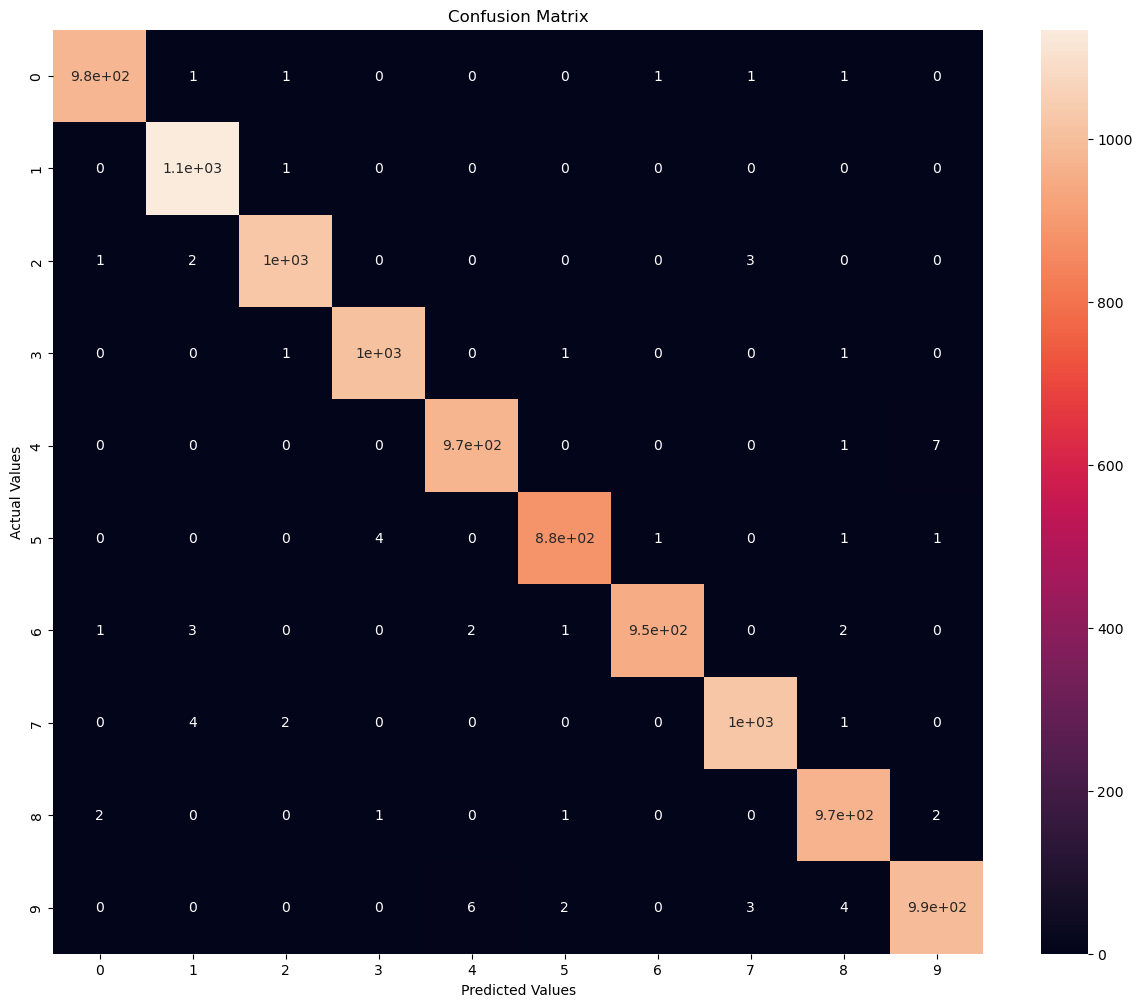

In [13]:
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


plt.figure(figsize=(15,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

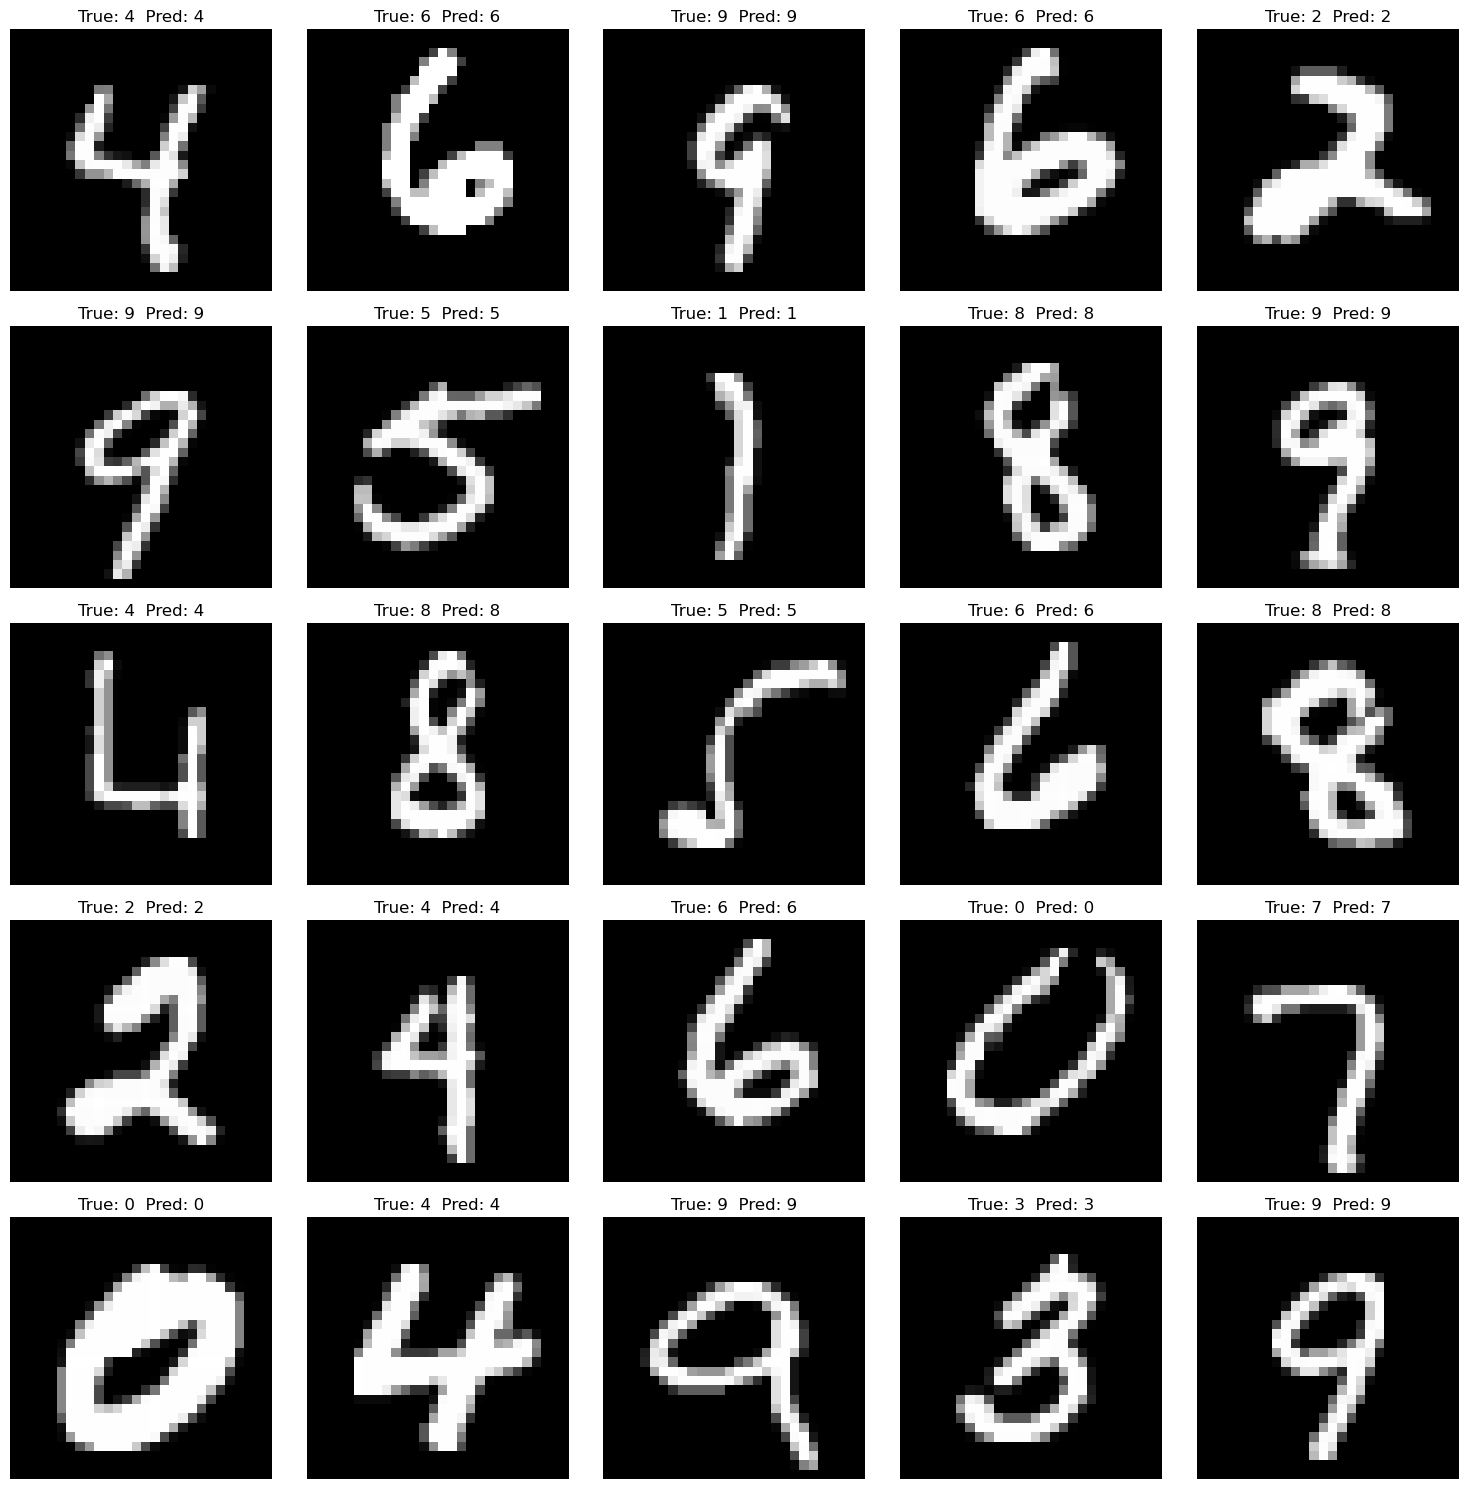

In [14]:
# Sample 25 random indices
random_indices = np.random.choice(len(test_images), size=25, replace=False)

# Create a 5x5 grid of subplots with shared axes
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# Iterate through the selected indices and plot the images
for i, ax in enumerate(axes.flat):
    image_index = random_indices[i]
    # Denormalize the image if needed (assuming normalization to [0, 1])
    image = test_images[image_index].numpy().squeeze() * 255
    image = np.clip(image, 0, 255).astype(np.uint8)

    ax.imshow(image, cmap='gray')  # Adjust cmap if your images are color
    ax.set_title(f"True: {y_test[image_index]}  Pred: {y_test_pred[image_index]}")
    ax.axis('off')

plt.tight_layout()
plt.show()